In [1]:
# Import relevant modules
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from classy import Class
import pybird
from importlib import reload
import os
from scipy.interpolate import interp1d
from copy import deepcopy

Text(0.5, 1.0, 'ABC123 vs $\\mathrm{ABC123}^{123}$')

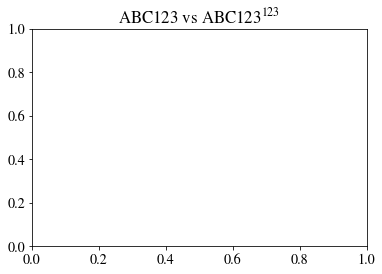

In [2]:
font = {'size': 14}
axislabelfontsize='large'
matplotlib.rc('font', **font)
matplotlib.mathtext.rcParams['legend.fontsize']='medium'
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.pyplot.title(r'ABC123 vs $\mathrm{ABC123}^{123}$')

In [3]:
zpk = 0.55

In [4]:
from scipy.optimize import fsolve

def get_masses(sum_masses, hierarchy='NH'):
    # a function returning the three masses given the Delta m^2, the total mass, and the hierarchy (e.g. 'IN' or 'IH')
    # Values are in the latest PDG
    # any string containing letter 'n' will be considered as refering to normal hierarchy
    if 'n' in hierarchy.lower():
        # Normal hierarchy massive neutrinos. Calculates the individual
        # neutrino masses from M_tot_NH and deletes M_tot_NH
        delta_m_squared_21 = 7.37e-5
        delta_m_squared_31 = 2.56e-3
        def m1_func(m1, M_tot):
            return M_tot**2 - (m1 + np.sqrt(m1**2 + delta_m_squared_21) + np.sqrt(m1**2 + delta_m_squared_31))**2
        m1, opt_output, success, output_message = fsolve(
            m1_func, sum_masses/3., (sum_masses), full_output=True, xtol=1e-04, maxfev=500)
        m1 = m1[0]
        m2 = (delta_m_squared_21 + m1**2.)**0.5
        m3 = (delta_m_squared_31 + m1**2.)**0.5
        return m1, m2, m3
    else:
        return None

In [5]:
def load_cosmo(basedir, chainname, skycut=1, nu=False):
    bf = np.loadtxt(os.path.join(basedir, chainname, '%s.bestfit') % chainname)
    if bf[2]>2.: bf[2] /= 100.
    if nu: 
        cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], 
                    'N_ur': 0.00641, 'N_ncdm': 3, 'm_ncdm': r'%g, %g, %g' % get_masses(bf[5])}
            
        print (cosmo)
    else: cosmo = {'omega_b': bf[0], 'omega_cdm': bf[1], 'h': bf[2], 'ln10^{10}A_s': bf[3], 'n_s': bf[4], }
    if nu:
        if skycut ==1: b1c2 = np.array([bf[6], bf[7]])
        elif skycut ==2: b1c2 = np.array([bf[8], bf[9]])
        elif skycut ==3: b1c2 = np.array([bf[10], bf[11]])
        elif skycut ==4: b1c2 = np.array([bf[12], bf[13]])
    else: b1c2 = np.array([bf[5], bf[6]])
    return cosmo, b1c2

In [6]:
#cosmo, b1c2 = load_cosmo('/Users/pierre/Documents/github/montepython_public-3.3/wcdm/', 'ncdm_eft_bao', nu=True)
cosmo = {'omega_b': 0.02303, 'omega_cdm': 0.11711, 'h': 0.7, 'ln10^{10}A_s': 3.06652, 'n_s': 0.96}
b1c2 = np.array([2., 0.8])

In [7]:
Mref = Class()
cosmoref = {'omega_b': 0.02303, 'omega_cdm': 0.310*0.7**2-0.02303, 'h': 0.7, 'ln10^{10}A_s': 3.06652, 'n_s': 0.96}
Mref.set(cosmoref)
Mref.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
Mref.compute()
print (Mref.Omega0_m())

0.31


In [24]:
Mfit = Class()
Omega_m = 0.286# 0.277
cosmofit = {'omega_b': 0.02303, 'omega_cdm': Omega_m*0.7**2-0.02303, 'h': 0.7, 'ln10^{10}A_s': 3.06652, 'n_s': 0.96}
Mfit.set(cosmofit)
Mfit.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
Mfit.compute()
print (Mfit.Omega0_m())

0.286


In [25]:
Mtrue = Class()
cosmo = {'omega_b': 0.02303, 'omega_cdm': 0.11711, 'h': 0.7, 'ln10^{10}A_s': 3.06652, 'n_s': 0.96}
Mtrue.set(cosmo)
Mtrue.set({'output': 'mPk', 'P_k_max_h/Mpc': 1.0,'z_max_pk': zpk})
Mtrue.compute()
print(Mtrue.Omega0_m())

0.28600000000000003


In [83]:
zeff = 0.55
ztrue = 0.5

qperp = Mtrue.angular_distance(zeff) / Mref.angular_distance(zeff) * Mtrue.angular_distance(ztrue) / Mtrue.angular_distance(zeff)  
qpar = Mref.Hubble(zeff) / Mtrue.Hubble(zeff) * Mtrue.Hubble(zeff) / Mtrue.Hubble(ztrue)  

# this is good, I do not why
zgood = 0.55
qperp_good = Mfit.angular_distance(zgood) / Mref.angular_distance(zgood)  
qpar_good = Mref.Hubble(zgood) / Mfit.Hubble(zgood) 

Dtrue = Mtrue.scale_independent_growth_factor(ztrue)
Dgood = Mfit.scale_independent_growth_factor(zgood)

ftrue = Mtrue.scale_independent_growth_factor_f(ztrue)
fgood = Mfit.scale_independent_growth_factor_f(zgood)

amptrue = 1/(qperp**2 * qpar) * Dtrue**2
ampgood =  1/(qperp_good**2 * qpar_good) * Dgood**2


ampf2true = 1/(qperp**2 * qpar) * ftrue**2
ampf2good =  1/(qperp_good**2 * qpar_good) * fgood**2

ampD2f2true = 1/(qperp**2 * qpar) * Dtrue**2 * ftrue**2
ampD2f2good =  1/(qperp_good**2 * qpar_good) * Dgood**2 * fgood**2

ampbisptrue = 1/(qperp**4 * qpar**2) * Dtrue**4
ampbispgood =  1/(qperp_good**4 * qpar_good**2) * Dgood**4

print ('MONO', Dtrue**2 / Dgood**2, amptrue / ampgood)
print ('RATIO MONO/QUAD', ftrue**2 / fgood**2) #, ampf2true / ampf2good)
print ('QUAD', Dtrue**2 * ftrue**2 / (Dgood**2 * fgood**2) , ampD2f2true / ampD2f2good)
print ('BISP', Dtrue**4 / Dgood**4, ampbisptrue / ampbispgood )

# If f goes down, b1 goes down, As goes up!

MONO 1.0501342021945945 1.1265283627655143
RATIO MONO/QUAD 0.9560218286288665
QUAD 1.003951220287792 1.07698570537337
BISP 1.1027818426188774 1.2690661521151507


In [80]:
Mtrue.angular_distance(ztrue) / Mtrue.angular_distance(zeff) 

0.9516604608631468

In [81]:
Mtrue.Hubble(ztrue) / Mtrue.Hubble(zeff) 

0.9715415497739536

In [82]:
1/0.9063015641247667

1.1033854950539776

In [529]:
#bs = [b1c2[0], b1c2[1], 1.312043,  1.548082, -1.548082 * 8**.5 * 0.7, -3.868042, 0.8517391]
bs = [b1c2[0], b1c2[1], -1.17855741,  0.41561274, -3.4946073, 0.99198482, -1.61644689]
# bs = [2., 0.8, 0.2, 0.8, 0.2, -4., 0]
bdict = { "b1": bs[0], "b2": bs[1]/np.sqrt(2.), "b3": bs[2], "b4":  bs[1]/np.sqrt(2.), 
 "cct": bs[3], "cr1": bs[4], 'ce0': bs[5], 'ce2': bs[6], 'ce1': 0. }
print (bdict)

{'b1': 2.0, 'b2': 0.565685424949238, 'b3': -1.17855741, 'b4': 0.565685424949238, 'cct': 0.41561274, 'cr1': -3.4946073, 'ce0': 0.99198482, 'ce2': -1.61644689, 'ce1': 0.0}


BOSS CMASS relative error

In [530]:
from numpy.linalg import inv
datapath = '/Users/pierre/Documents/github/montepython_public-3.3/data/pybird/'
kb, pb1,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzNGC.dat'), unpack=True)
_, pb2,_ = np.loadtxt( os.path.join(datapath, 'DataSims', 'ps1D_highzSGC.dat'), unpack=True)
cov1 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzNGC.dat') )
cov2 = np.loadtxt( os.path.join(datapath, 'Covariance', 'Cov_highzSGC.dat') )
cov = inv ( inv(cov1) + inv(cov2) )
pb = np.dot( np.dot(pb1, inv(cov1)) + np.dot(pb2, inv(cov2)) , cov ) # CMASS NGC + SGC
# np.savetxt('../../k_ps_err_CMASS.dat', np.vstack([kb, pb, np.sqrt(np.diag(cov))]).T)
kb = kb.reshape(3,-1)[0]
pb = pb.reshape(3,-1)
sb = np.sqrt(np.diag(cov)).reshape(3,-1)
eb = (sb/pb)[:,np.where(kb<0.35)[0]]
kb = kb[np.where(kb<0.35)[0]]
kd = kb

Typical galaxy count distribution

In [531]:
# zz = np.linspace(zpk-0.3, zpk+0.3, 100)
# sigmaz = 0.1
# def Gaussian(z, p=(zpk, sigmaz)):
#     zc, dz = p
#     return np.exp(-0.5*(z-zc)**2/dz**2)
# nz = Gaussian(zz)
# nz /= np.trapz(nz, x=zz)
# plt.plot(zz, nz)

Nseries galaxy count distribution

0.5436197203557319


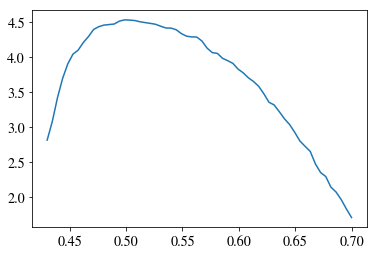

In [567]:
download_dir = os.path.join('/', 'Users', 'pierre', 'Documents', 'EFTofLSS', 'BOSS_measurements', 'catalogs', 'Nseries_prerecon')
z, n, wfkp, w = np.loadtxt(os.path.join(download_dir, 'nbar_DR12v5_CMASS_North_om0p31_Pfkp10000.dat'), unpack=True, usecols=(0,3,4,6))
zz = np.linspace(0.43, 0.7, 60)
nz = interp1d(z, n*wfkp, kind='cubic')(zz)
nz /= np.trapz(nz, x=zz)
plt.plot(zz, nz)
print (np.trapz(zz * nz**2, x=zz) / np.trapz(nz**2, x=zz))

Growth function ratio

In [591]:
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [592]:
zpk = 0.5

In [593]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6,  'km': 0.7, 'knl': 0.7, 'optiresum': True, "with_stoch": True,
    'with_redshift_bin': True, 'zz': zz,'nz': nz, 
    'with_AP': True, 'Omega_m_AP': 0.310, 'z_AP': 0.55
})
correlator.compute(cosmo, module='class')
redpk = correlator.get(bdict)

In [595]:
reload(pybird)

<module 'pybird' from '/Users/pierre/Documents/github/pybird/pybird_dev/pybird.py'>

In [623]:
zpk = 0.5

In [624]:
correlator = pybird.Correlator()
correlator.set({
    'output': 'bPk', 'multipole': 2, 'xdata': kd, 'z': zpk, 'kmax': 0.6, 'km': 0.7, 'knl': 0.7, 'optiresum': True, "with_stoch": True, 
    'with_AP': True, 'Omega_m_AP': 0.310, 'z_AP': zpk
        })
correlator.compute(cosmo, module='class')
eqpk = correlator.get(bdict)

Summary plot

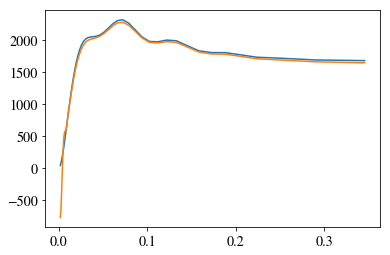

In [625]:
plt.plot(kd, kd * eqpk[0])
plt.plot(kd, kd * (redpk[0]-.85/4e-4))

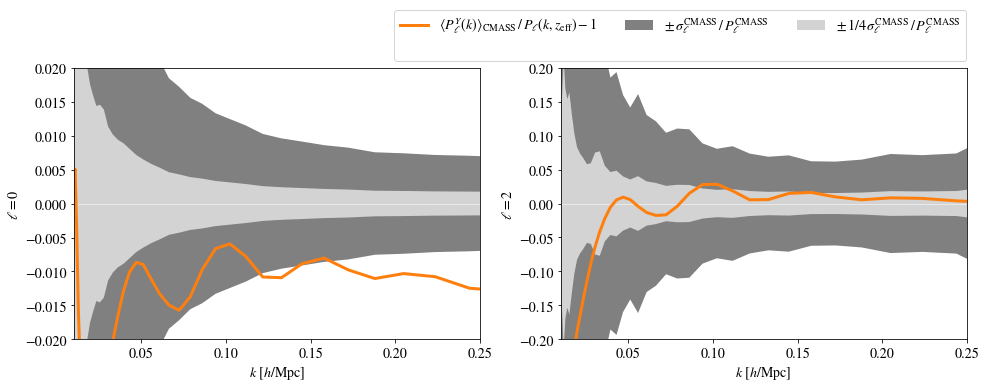

In [626]:
f, ax = plt.subplots(1, 2, figsize=(16,5))
f.subplots_adjust(wspace=.2)
ax[0].plot(kd, 0*kd, 'white', linewidth=0.5)
ax[0].plot(kd, (redpk[0]-.84/4e-4)/eqpk[0]-1, 'C1', lw=3, label=r'$\langle P_\ell^Y (k) \rangle_{\rm CMASS} \, / \, P_\ell(k, z_{\rm eff}) - 1$')
ax[0].fill_between(kd, -eb[0], eb[0], facecolor='grey')
ax[0].fill_between(kd, -eb[0]/4., eb[0]/4., facecolor='lightgrey')
ax[0].set_ylim(-0.02, +0.02)
ax[0].set_ylabel(r'$\ell=0$')
ax[0].set_xlim(0.01, 0.25)
ax[0].set_xlabel(r'$k$ [$h$/Mpc]')

ax[1].set_xlabel(r'$k$ [$h$/Mpc]')
ax[1].plot(kd, 0*kd, 'white', linewidth=0.5)
ax[1].plot(kd, redpk[1]/eqpk[1]-1, 'C1', lw=3)
ax[1].plot(kd, np.ones_like(kd), 'white', label=' ')
ax[1].fill_between(kd, -eb[1], eb[1], facecolor='grey', label=r'$\pm \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].fill_between(kd[0:], -eb[1,0:]/4., eb[1,0:]/4., facecolor='lightgrey', label=r'$\pm \, 1/4 \, \sigma_\ell^{\rm CMASS} \, / \, P_\ell^{\rm CMASS}$')
ax[1].set_ylim(-0.2, +0.2)
ax[1].set_ylabel(r'$\ell=2$')
ax[1].set_xlim(0.01, 0.25)
ax[1].set_xlabel(r'$k$ [$h$/Mpc]')

f.legend(bbox_to_anchor=(0.845, 1.07), ncol=3, loc='upper right')

# plt.savefig('/Users/pierre/Documents/github/montepython_public-3.3/time/paper_fig/2021/pk.pdf', bbox_inches='tight')